# Target Problem

The project proposes to use a deep reinforcement learning framework to learn a profitable stock trading strategy, with the goal to optimize the cumulative return and Alpha. It would select S&P500 Index with the top 20 market capitalization stocks as our trading stock pool. The input to the algorithm is the market trend for these stocks in the last month, remaining balance, and current portfolio. The model agent output is a series of trading actions among stocks. The available trading
action options are: sell, buy and hold. The market data in the most recent months will be used to feed
the model performance evaluation.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:

* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: SP500 top 20 companies


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


## Environment Setup

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
from rl.config import config
from rl.marketdata.yahoodownloader import YahooDownloader
from rl.preprocessing.preprocessors import FeatureEngineer
from rl.preprocessing.data import data_split
from rl.env.env_stocktrading import StockTradingEnv
from rl.model.models import DRLAgent
from rl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import itertools

D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


### Cache Folders

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

### Fetch Data

In [3]:
# from config.py start_date is a string
start_date = config.START_DATE
# from config.py end_date is a string
end_date = config.END_DATE
# from config.py split_date is a string
split_date = config.SPLIT_DATE
# config target ticker
target_ticker = config.SP500_20_TICKER
# config tech_indicator_list
tech_indicator_list = config.TECHNICAL_INDICATORS_LIST
print("training period: {}-{}, testing period: {}-{}\n".format(start_date, split_date, split_date, end_date))
print("target ticker list:\n {}\n".format(target_ticker))
print("tech_indicator_list:\n {}\n".format(tech_indicator_list))

training period: 2000-01-01-2019-01-01, testing period: 2019-01-01-2021-01-01

target ticker list:
 ['AAPL', 'MSFT', 'AMZN', 'BRK-B', 'JPM', 'JNJ', 'UNH', 'HD', 'PG', 'NVDA', 'DIS', 'BAC', 'CMCSA', 'XOM', 'VZ', 'T', 'ADBE', 'PFE', 'CSCO', 'INTC']

tech_indicator_list:
 ['macd', 'boll_ub', 'boll_lb', 'rsi_10', 'rsi_20', 'cci_10', 'cci_20', 'dx_30', 'close_20_sma', 'close_60_sma', 'close_120_sma', 'close_20_ema', 'close_60_ema', 'close_120_ema']



In [4]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = target_ticker).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
df.shape

(105680, 8)

In [6]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800.0,AAPL,0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0
2,2000-01-03,81.500000,89.562500,79.046875,89.375000,16117600.0,AMZN,0
3,2000-01-03,25.125000,25.125000,24.000000,13.952057,13705800.0,BAC,0
4,2000-01-03,36.500000,36.580002,34.820000,35.299999,875000.0,BRK-B,0


## Data Preprocessing
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

### Feature Engineering

In [7]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [8]:
processed.shape
processed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800.0,AAPL,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,0.859423,0.859423,0.859423,0.859423,0.859423,0.859423,0.0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,16.274673,16.274673,16.274673,16.274673,16.274673,16.274673,0.0
2,2000-01-03,81.500000,89.562500,79.046875,89.375000,16117600.0,AMZN,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,89.375000,89.375000,89.375000,89.375000,89.375000,89.375000,0.0
3,2000-01-03,25.125000,25.125000,24.000000,13.952057,13705800.0,BAC,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,13.952057,13.952057,13.952057,13.952057,13.952057,13.952057,0.0
4,2000-01-03,36.500000,36.580002,34.820000,35.299999,875000.0,BRK-B,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,35.299999,35.299999,35.299999,35.299999,35.299999,35.299999,0.0


### Data display

In [9]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
processed_full = processed_full.fillna(0)

In [10]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2000-01-03,AAPL,0.936384,1.004464,0.907924,0.859423,535796800.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,0.859423,0.859423,0.859423,0.859423,0.859423,0.859423,0.0
1,2000-01-03,ADBE,16.812500,16.875000,16.062500,16.274673,7384400.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,16.274673,16.274673,16.274673,16.274673,16.274673,16.274673,0.0
2,2000-01-03,AMZN,81.500000,89.562500,79.046875,89.375000,16117600.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,89.375000,89.375000,89.375000,89.375000,89.375000,89.375000,0.0
3,2000-01-03,BAC,25.125000,25.125000,24.000000,13.952057,13705800.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,13.952057,13.952057,13.952057,13.952057,13.952057,13.952057,0.0
4,2000-01-03,BRK-B,36.500000,36.580002,34.820000,35.299999,875000.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,35.299999,35.299999,35.299999,35.299999,35.299999,35.299999,0.0
5,2000-01-03,CMCSA,16.145832,16.333332,15.062500,12.189544,2333700.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,12.189544,12.189544,12.189544,12.189544,12.189544,12.189544,0.0
6,2000-01-03,CSCO,54.968750,55.125000,51.781250,40.118656,53076000.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,40.118656,40.118656,40.118656,40.118656,40.118656,40.118656,0.0
7,2000-01-03,DIS,28.855125,29.533344,28.361876,23.115248,8402230.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,23.115248,23.115248,23.115248,23.115248,23.115248,23.115248,0.0
8,2000-01-03,HD,68.625000,69.187500,63.812500,42.563168,12030800.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,42.563168,42.563168,42.563168,42.563168,42.563168,42.563168,0.0
9,2000-01-03,INTC,41.632812,43.687500,41.625000,27.002798,57710200.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,27.002798,27.002798,27.002798,27.002798,27.002798,27.002798,0.0


### Data Split

In [11]:
train = data_split(processed_full, start_date, split_date)
evaluate = data_split(processed_full, split_date, end_date)
print(train.shape)
print(evaluate.shape)

(95580, 23)
(10100, 23)


## RL Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [12]:
initialData = train.loc[0,:]
print(initialData)

         date    tic       open       high        low      close       volume  \
0  2000-01-03   AAPL   0.936384   1.004464   0.907924   0.859423  535796800.0   
0  2000-01-03   ADBE  16.812500  16.875000  16.062500  16.274673    7384400.0   
0  2000-01-03   AMZN  81.500000  89.562500  79.046875  89.375000   16117600.0   
0  2000-01-03    BAC  25.125000  25.125000  24.000000  13.952057   13705800.0   
0  2000-01-03  BRK-B  36.500000  36.580002  34.820000  35.299999     875000.0   
0  2000-01-03  CMCSA  16.145832  16.333332  15.062500  12.189544    2333700.0   
0  2000-01-03   CSCO  54.968750  55.125000  51.781250  40.118656   53076000.0   
0  2000-01-03    DIS  28.855125  29.533344  28.361876  23.115248    8402230.0   
0  2000-01-03     HD  68.625000  69.187500  63.812500  42.563168   12030800.0   
0  2000-01-03   INTC  41.632812  43.687500  41.625000  27.002798   57710200.0   
0  2000-01-03    JNJ  46.562500  46.875000  45.781250  26.644770    4642400.0   
0  2000-01-03    JPM  49.833

In [13]:
evaluate.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2019-01-02,AAPL,38.722500,39.712502,38.557499,38.439735,148158800.0,2.0,-2.013469,44.430054,...,5.338357,-62.506106,42.250808,39.907269,46.409359,48.900092,39.894455,44.458658,46.304234,40.714603
0,2019-01-02,ADBE,219.910004,226.169998,219.000000,224.570007,2784100.0,2.0,-5.282335,259.815658,...,42.283562,-46.078026,18.279805,231.481001,239.189334,249.605750,228.071064,238.013177,241.061149,40.714603
0,2019-01-02,AMZN,1465.199951,1553.359985,1460.930054,1539.130005,7983100.0,2.0,-46.142964,1783.043118,...,71.986956,-29.701621,16.053433,1558.427496,1640.886670,1772.662920,1531.028514,1632.326567,1675.234803,40.714603
0,2019-01-02,BAC,24.080000,25.139999,24.010000,23.649902,71836300.0,2.0,-0.669456,25.783587,...,82.345511,-11.196459,18.930726,23.473258,25.393073,27.097682,23.590685,25.158157,26.235524,40.714603
0,2019-01-02,BRK-B,201.729996,204.399994,201.149994,202.800003,4802100.0,2.0,-2.760708,215.345783,...,106.526697,18.020183,2.953389,201.200500,208.270668,208.078834,201.656593,206.289644,206.078162,40.714603


In [14]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicator_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 20, State Space: 321


In [15]:
env_params = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-6
}

e_train_gym = StockTradingEnv(df = train, **env_params)

[1000000, 0.859423041343689, 16.274673461914062, 89.375, 13.952056884765625, 35.29999923706055, 12.189543724060059, 40.118656158447266, 23.11524772644043, 42.563167572021484, 27.002798080444336, 26.6447696685791, 25.863813400268555, 36.93210220336914, 3.585430383682251, 14.565584182739258, 30.248369216918945, 15.941187858581543, 5.632353782653809, 20.573511123657227, 20.461938858032227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.720722899924667, 0.720722899924667, 0.720722899924667, 0.72072289992

## Environment for Training



In [16]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

[1000000, 0.859423041343689, 16.274673461914062, 89.375, 13.952056884765625, 35.29999923706055, 12.189543724060059, 40.118656158447266, 23.11524772644043, 42.563167572021484, 27.002798080444336, 26.6447696685791, 25.863813400268555, 36.93210220336914, 3.585430383682251, 14.565584182739258, 30.248369216918945, 15.941187858581543, 5.632353782653809, 20.573511123657227, 20.461938858032227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.720722899924667, 0.720722899924667, 0.720722899924667, 0.72072289992

## RL Models Training: (A2C DDPG, PPO, TD3, SAC)
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Actor-Critic


In [17]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {
    "n_steps": 5, 
    "ent_coef": 0.005, 
    "learning_rate": 0.0001
}
model_a2c = agent.get_model("a2c", model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0001}
Using cpu device


In [18]:
trained_a2c = agent.train_model(
    model=model_a2c, 
    tb_log_name='a2c',
    total_timesteps=100000)

[1000000, 0.859423041343689, 16.274673461914062, 89.375, 13.952056884765625, 35.29999923706055, 12.189543724060059, 40.118656158447266, 23.11524772644043, 42.563167572021484, 27.002798080444336, 26.6447696685791, 25.863813400268555, 36.93210220336914, 3.585430383682251, 14.565584182739258, 30.248369216918945, 15.941187858581543, 5.632353782653809, 20.573511123657227, 20.461938858032227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.720722899924667, 0.720722899924667, 0.720722899924667, 0.72072289992

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 800      |
|    time_elapsed       | 40       |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -28.7    |
|    explained_variance | -10.2    |
|    learning_rate      | 0.0001   |
|    n_updates          | 799      |
|    policy_loss        | -1.13    |
|    std                | 1.02     |
|    value_loss         | 0.0471   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 900      |
|    time_elapsed       | 45       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -28.7    |
|    explained_variance | -3.62    |
|    learning_rate      | 0.0001   |
|    n_updates          | 899      |
|    policy_loss        | -0.331   |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 1200     |
|    time_elapsed       | 62       |
|    total_timesteps    | 6000     |
| train/                |          |
|    entropy_loss       | -28.8    |
|    explained_variance | -304     |
|    learning_rate      | 0.0001   |
|    n_updates          | 1199     |
|    policy_loss        | 1.7      |
|    std                | 1.02     |
|    value_loss         | 0.0405   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 1300     |
|    time_elapsed       | 67       |
|    total_timesteps    | 6500     |
| train/                |          |
|    entropy_loss       | -28.8    |
|    explained_variance | -57.6    |
|    learning_rate      | 0.0001   |
|    n_updates          | 1299     |
|    policy_loss        | -6.25    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.56e+06 |
|    total_cost         | 2.16e+05 |
|    total_reward       | 2.56e+06 |
|    total_reward_pct   | 256      |
|    total_trades       | 89660    |
| time/                 |          |
|    fps                | 100      |
|    iterations         | 2000     |
|    time_elapsed       | 99       |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -28.9    |
|    explained_variance | -27.5    |
|    learning_rate      | 0.0001   |
|    n_updates          | 1999     |
|    policy_loss        | 5.07     |
|    std                | 1.03     |
|    value_loss         | 0.0332   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 101      |
|    iterations         | 2100     |
|    time_elapsed       | 103      |
|    total_timesteps    | 10500    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.63e+06 |
|    total_cost         | 1.98e+05 |
|    total_reward       | 1.63e+06 |
|    total_reward_pct   | 163      |
|    total_trades       | 86715    |
| time/                 |          |
|    fps                | 104      |
|    iterations         | 2900     |
|    time_elapsed       | 139      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -29      |
|    explained_variance | -17.3    |
|    learning_rate      | 0.0001   |
|    n_updates          | 2899     |
|    policy_loss        | -0.181   |
|    std                | 1.03     |
|    value_loss         | 0.000354 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 104      |
|    iterations         | 3000     |
|    time_elapsed       | 143      |
|    total_timesteps    | 15000    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.97e+06 |
|    total_cost         | 1.8e+05  |
|    total_reward       | 1.97e+06 |
|    total_reward_pct   | 197      |
|    total_trades       | 83069    |
| time/                 |          |
|    fps                | 106      |
|    iterations         | 3900     |
|    time_elapsed       | 183      |
|    total_timesteps    | 19500    |
| train/                |          |
|    entropy_loss       | -29.3    |
|    explained_variance | -214     |
|    learning_rate      | 0.0001   |
|    n_updates          | 3899     |
|    policy_loss        | -1.36    |
|    std                | 1.05     |
|    value_loss         | 0.0215   |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 106       |
|    iterations         | 4000      |
|    time_elapsed       | 188       |
|    total_timesteps    | 20000  

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.01e+06 |
|    total_cost         | 1.99e+05 |
|    total_reward       | 2.01e+06 |
|    total_reward_pct   | 201      |
|    total_trades       | 84981    |
| time/                 |          |
|    fps                | 107      |
|    iterations         | 4800     |
|    time_elapsed       | 223      |
|    total_timesteps    | 24000    |
| train/                |          |
|    entropy_loss       | -29.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0001   |
|    n_updates          | 4799     |
|    policy_loss        | -0.217   |
|    std                | 1.06     |
|    value_loss         | 7.62e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 107      |
|    iterations         | 4900     |
|    time_elapsed       | 227      |
|    total_timesteps    | 24500    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.47e+06 |
|    total_cost         | 2.1e+05  |
|    total_reward       | 2.47e+06 |
|    total_reward_pct   | 247      |
|    total_trades       | 85391    |
| time/                 |          |
|    fps                | 108      |
|    iterations         | 5800     |
|    time_elapsed       | 267      |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -29.8    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0001   |
|    n_updates          | 5799     |
|    policy_loss        | 0.379    |
|    std                | 1.07     |
|    value_loss         | 0.000196 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 108       |
|    iterations         | 5900      |
|    time_elapsed       | 272       |
|    total_timesteps    | 29500  

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.93e+06 |
|    total_cost         | 2.07e+05 |
|    total_reward       | 2.93e+06 |
|    total_reward_pct   | 293      |
|    total_trades       | 84831    |
| time/                 |          |
|    fps                | 108      |
|    iterations         | 6700     |
|    time_elapsed       | 307      |
|    total_timesteps    | 33500    |
| train/                |          |
|    entropy_loss       | -30      |
|    explained_variance | 0        |
|    learning_rate      | 0.0001   |
|    n_updates          | 6699     |
|    policy_loss        | 0.203    |
|    std                | 1.08     |
|    value_loss         | 5.35e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 108      |
|    iterations         | 6800     |
|    time_elapsed       | 312      |
|    total_timesteps    | 34000    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 7.59e+06 |
|    total_cost         | 2.22e+05 |
|    total_reward       | 6.59e+06 |
|    total_reward_pct   | 659      |
|    total_trades       | 84656    |
| time/                 |          |
|    fps                | 109      |
|    iterations         | 7700     |
|    time_elapsed       | 352      |
|    total_timesteps    | 38500    |
| train/                |          |
|    entropy_loss       | -30.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0001   |
|    n_updates          | 7699     |
|    policy_loss        | 0.0362   |
|    std                | 1.1      |
|    value_loss         | 8.34e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 109      |
|    iterations         | 7800     |
|    time_elapsed       | 356      |
|    total_timesteps    | 39000    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.84e+06 |
|    total_cost         | 2.25e+05 |
|    total_reward       | 2.84e+06 |
|    total_reward_pct   | 284      |
|    total_trades       | 83467    |
| time/                 |          |
|    fps                | 109      |
|    iterations         | 8700     |
|    time_elapsed       | 396      |
|    total_timesteps    | 43500    |
| train/                |          |
|    entropy_loss       | -30.5    |
|    explained_variance | -109     |
|    learning_rate      | 0.0001   |
|    n_updates          | 8699     |
|    policy_loss        | -4.72    |
|    std                | 1.11     |
|    value_loss         | 0.0415   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 109      |
|    iterations         | 8800     |
|    time_elapsed       | 400      |
|    total_timesteps    | 44000    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.31e+06 |
|    total_cost         | 2.13e+05 |
|    total_reward       | 1.31e+06 |
|    total_reward_pct   | 131      |
|    total_trades       | 83970    |
| time/                 |          |
|    fps                | 110      |
|    iterations         | 9600     |
|    time_elapsed       | 435      |
|    total_timesteps    | 48000    |
| train/                |          |
|    entropy_loss       | -30.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0001   |
|    n_updates          | 9599     |
|    policy_loss        | 0.209    |
|    std                | 1.12     |
|    value_loss         | 0.000178 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 110       |
|    iterations         | 9700      |
|    time_elapsed       | 440       |
|    total_timesteps    | 48500  

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.74e+06 |
|    total_cost         | 2.22e+05 |
|    total_reward       | 1.74e+06 |
|    total_reward_pct   | 174      |
|    total_trades       | 86291    |
| time/                 |          |
|    fps                | 109      |
|    iterations         | 10600    |
|    time_elapsed       | 482      |
|    total_timesteps    | 53000    |
| train/                |          |
|    entropy_loss       | -31      |
|    explained_variance | -112     |
|    learning_rate      | 0.0001   |
|    n_updates          | 10599    |
|    policy_loss        | -1.73    |
|    std                | 1.14     |
|    value_loss         | 0.0201   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 109      |
|    iterations         | 10700    |
|    time_elapsed       | 487      |
|    total_timesteps    | 53500    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.58e+06 |
|    total_cost         | 2.33e+05 |
|    total_reward       | 1.58e+06 |
|    total_reward_pct   | 158      |
|    total_trades       | 86532    |
| time/                 |          |
|    fps                | 109      |
|    iterations         | 11500    |
|    time_elapsed       | 526      |
|    total_timesteps    | 57500    |
| train/                |          |
|    entropy_loss       | -31.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0001   |
|    n_updates          | 11499    |
|    policy_loss        | 0.00983  |
|    std                | 1.15     |
|    value_loss         | 2.49e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 109      |
|    iterations         | 11600    |
|    time_elapsed       | 530      |
|    total_timesteps    | 58000    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.64e+06 |
|    total_cost         | 2.37e+05 |
|    total_reward       | 1.64e+06 |
|    total_reward_pct   | 164      |
|    total_trades       | 86715    |
| time/                 |          |
|    fps                | 109      |
|    iterations         | 12500    |
|    time_elapsed       | 570      |
|    total_timesteps    | 62500    |
| train/                |          |
|    entropy_loss       | -31.4    |
|    explained_variance | -230     |
|    learning_rate      | 0.0001   |
|    n_updates          | 12499    |
|    policy_loss        | 4.56     |
|    std                | 1.17     |
|    value_loss         | 0.026    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 109      |
|    iterations         | 12600    |
|    time_elapsed       | 574      |
|    total_timesteps    | 63000    |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 2.4e+06   |
|    total_cost         | 2.46e+05  |
|    total_reward       | 1.4e+06   |
|    total_reward_pct   | 140       |
|    total_trades       | 85587     |
| time/                 |           |
|    fps                | 109       |
|    iterations         | 13400     |
|    time_elapsed       | 609       |
|    total_timesteps    | 67000     |
| train/                |           |
|    entropy_loss       | -31.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0001    |
|    n_updates          | 13399     |
|    policy_loss        | -0.394    |
|    std                | 1.18      |
|    value_loss         | 0.00014   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 110      |
|    iterations         | 13500    |
|    time_elapsed       | 613      |
|    total_timest

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.65e+06 |
|    total_cost         | 2.33e+05 |
|    total_reward       | 2.65e+06 |
|    total_reward_pct   | 265      |
|    total_trades       | 86319    |
| time/                 |          |
|    fps                | 110      |
|    iterations         | 14400    |
|    time_elapsed       | 652      |
|    total_timesteps    | 72000    |
| train/                |          |
|    entropy_loss       | -31.9    |
|    explained_variance | -27.2    |
|    learning_rate      | 0.0001   |
|    n_updates          | 14399    |
|    policy_loss        | 3.24     |
|    std                | 1.2      |
|    value_loss         | 0.0121   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 110      |
|    iterations         | 14500    |
|    time_elapsed       | 657      |
|    total_timesteps    | 72500    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.78e+06 |
|    total_cost         | 2.12e+05 |
|    total_reward       | 7.77e+05 |
|    total_reward_pct   | 77.7     |
|    total_trades       | 85223    |
| time/                 |          |
|    fps                | 110      |
|    iterations         | 15300    |
|    time_elapsed       | 692      |
|    total_timesteps    | 76500    |
| train/                |          |
|    entropy_loss       | -32.2    |
|    explained_variance | -1.4e+03 |
|    learning_rate      | 0.0001   |
|    n_updates          | 15299    |
|    policy_loss        | 0.963    |
|    std                | 1.21     |
|    value_loss         | 0.00276  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 110      |
|    iterations         | 15400    |
|    time_elapsed       | 696      |
|    total_timesteps    | 77000    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.58e+06 |
|    total_cost         | 2.2e+05  |
|    total_reward       | 1.58e+06 |
|    total_reward_pct   | 158      |
|    total_trades       | 85003    |
| time/                 |          |
|    fps                | 110      |
|    iterations         | 16300    |
|    time_elapsed       | 736      |
|    total_timesteps    | 81500    |
| train/                |          |
|    entropy_loss       | -32.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0001   |
|    n_updates          | 16299    |
|    policy_loss        | -1.13    |
|    std                | 1.23     |
|    value_loss         | 0.00122  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 110      |
|    iterations         | 16400    |
|    time_elapsed       | 741      |
|    total_timesteps    | 82000    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.14e+06 |
|    total_cost         | 2.02e+05 |
|    total_reward       | 1.14e+06 |
|    total_reward_pct   | 114      |
|    total_trades       | 82643    |
| time/                 |          |
|    fps                | 110      |
|    iterations         | 17300    |
|    time_elapsed       | 780      |
|    total_timesteps    | 86500    |
| train/                |          |
|    entropy_loss       | -32.8    |
|    explained_variance | -169     |
|    learning_rate      | 0.0001   |
|    n_updates          | 17299    |
|    policy_loss        | -2.4     |
|    std                | 1.25     |
|    value_loss         | 0.00612  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 110      |
|    iterations         | 17400    |
|    time_elapsed       | 785      |
|    total_timesteps    | 87000    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.56e+06 |
|    total_cost         | 1.22e+05 |
|    total_reward       | 5.62e+05 |
|    total_reward_pct   | 56.2     |
|    total_trades       | 78512    |
| time/                 |          |
|    fps                | 110      |
|    iterations         | 18200    |
|    time_elapsed       | 820      |
|    total_timesteps    | 91000    |
| train/                |          |
|    entropy_loss       | -33.2    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0001   |
|    n_updates          | 18199    |
|    policy_loss        | -0.794   |
|    std                | 1.27     |
|    value_loss         | 0.000681 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 110      |
|    iterations         | 18300    |
|    time_elapsed       | 824      |
|    total_timesteps    | 91500    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.88e+06 |
|    total_cost         | 1.62e+05 |
|    total_reward       | 8.83e+05 |
|    total_reward_pct   | 88.3     |
|    total_trades       | 80264    |
| time/                 |          |
|    fps                | 111      |
|    iterations         | 19200    |
|    time_elapsed       | 864      |
|    total_timesteps    | 96000    |
| train/                |          |
|    entropy_loss       | -33.6    |
|    explained_variance | -116     |
|    learning_rate      | 0.0001   |
|    n_updates          | 19199    |
|    policy_loss        | 1.38     |
|    std                | 1.3      |
|    value_loss         | 0.00296  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 111      |
|    iterations         | 19300    |
|    time_elapsed       | 868      |
|    total_timesteps    | 96500    |
|

### PPO

In [19]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo", model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [20]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

[1000000, 35.58379364013672, 146.72999572753906, 1020.0399780273438, 22.14950180053711, 174.0, 36.60380935668945, 28.084203720092773, 106.08326721191406, 135.3709716796875, 31.96147918701172, 118.55754852294922, 81.94001770019531, 68.97183227539062, 162.71319580078125, 27.042583465576172, 81.08613586425781, 30.936172485351562, 180.52418518066406, 40.6921272277832, 64.24020385742188, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2894361993929593, 1.8220685452191674, 15.017167247691987, 0.08406431311352591, 1.1357490462341673, -0.026440617077668094, 0.05961289837527417, 0.8463791427227108, -1.6073186081420943, 0.048102060442523964, 0.03791013174712532, 0.7503682872124386, 0.9608287005427201, 4.759640690759568, -0.02646470914959309, 0.5901037867335788, 0.09485337270742278, 2.0239038685743083, 0.3075708384421958, -0.25008968046444124, 36.858045940829186, 152.46336640512274, 1065.4252289085648, 23.090653965631255, 173.8376301886623, 37.01275619534707, 28.680472183212213, 105

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 5.2e+06     |
|    total_cost           | 2.66e+05    |
|    total_reward         | 4.2e+06     |
|    total_reward_pct     | 420         |
|    total_trades         | 92932       |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 3           |
|    time_elapsed         | 49          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.007471516 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.4       |
|    explained_variance   | -0.677      |
|    learning_rate        | 0.0001      |
|    loss                 | -0.169      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0223     |
|    std                  | 1           |
|    value_loss           | 0.0239

-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 6           |
|    time_elapsed         | 100         |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.005984498 |
|    clip_fraction        | 0.0797      |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.5       |
|    explained_variance   | 0.393       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.15       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0116     |
|    std                  | 1           |
|    value_loss           | 0.0205      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 7           |
|    time_elapsed         | 116   

-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 9           |
|    time_elapsed         | 150         |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.013638204 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.5       |
|    explained_variance   | 0.242       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.176      |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0194     |
|    std                  | 1.01        |
|    value_loss           | 0.0202      |
-----------------------------------------
[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.135417938232

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.3e+06     |
|    total_cost           | 2.05e+05    |
|    total_reward         | 2.3e+06     |
|    total_reward_pct     | 230         |
|    total_trades         | 88269       |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 17          |
|    time_elapsed         | 285         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.014435717 |
|    clip_fraction        | 0.065       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.5       |
|    explained_variance   | -4.29       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.158      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0116     |
|    std                  | 1.01        |
|    value_loss           | 0.0088

-----------------------------------------
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 20          |
|    time_elapsed         | 336         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.008006703 |
|    clip_fraction        | 0.0908      |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.5       |
|    explained_variance   | -0.0974     |
|    learning_rate        | 0.0001      |
|    loss                 | -0.136      |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0128     |
|    std                  | 1.01        |
|    value_loss           | 0.0971      |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 121          |
|    iterations           | 21           |
|    time_elapsed         | 35

-----------------------------------------
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 23          |
|    time_elapsed         | 386         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.011171446 |
|    clip_fraction        | 0.0827      |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.6       |
|    explained_variance   | -0.224      |
|    learning_rate        | 0.0001      |
|    loss                 | -0.162      |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0179     |
|    std                  | 1.01        |
|    value_loss           | 0.0105      |
-----------------------------------------
[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.135417938232

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

------------------------------------------
| environment/            |              |
|    portfolio_value      | 3.45e+06     |
|    total_cost           | 2.01e+05     |
|    total_reward         | 2.45e+06     |
|    total_reward_pct     | 245          |
|    total_trades         | 86794        |
| time/                   |              |
|    fps                  | 121          |
|    iterations           | 31           |
|    time_elapsed         | 520          |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0141350925 |
|    clip_fraction        | 0.108        |
|    clip_range           | 0.2          |
|    entropy_loss         | -28.6        |
|    explained_variance   | -2.65        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.168       |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.0156      |
|    std                  | 1.01         |
|    value_

-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 34          |
|    time_elapsed         | 570         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.015849248 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.6       |
|    explained_variance   | -0.0953     |
|    learning_rate        | 0.0001      |
|    loss                 | -0.152      |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.0151     |
|    std                  | 1.01        |
|    value_loss           | 0.02        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 35          |
|    time_elapsed         | 587   

-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 37          |
|    time_elapsed         | 620         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.014653164 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.6       |
|    explained_variance   | -1.55       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.173      |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.0185     |
|    std                  | 1.01        |
|    value_loss           | 0.00505     |
-----------------------------------------
[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.135417938232

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

day: 4778, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 4644198.94
total_reward: 3644198.94
total_cost: 223680.99
total_trades: 88611
Sharpe: 0.456
[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.12e+06    |
|    total_cost           | 2.23e+05    |
|    total_reward         | 2.12e+06    |
|    total_reward_pct     | 212         |
|    total_trades         | 88408       |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 45          |
|    time_elapsed         | 754         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.013831275 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.7       |
|    explained_variance   | -0.733      |
|    learning_rate        | 0.0001      |
|    loss                 | -0.193      |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.0155     |
|    std                  | 1.02        |
|    value_loss           | 0.0038

-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 48          |
|    time_elapsed         | 804         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.017241623 |
|    clip_fraction        | 0.0962      |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.7       |
|    explained_variance   | -0.781      |
|    learning_rate        | 0.0001      |
|    loss                 | -0.149      |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.0118     |
|    std                  | 1.02        |
|    value_loss           | 0.00742     |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 49         |
|    time_elapsed         | 821       

### DDPG

In [21]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
    'batch_size': 128, 
    'buffer_size': 100000, 
    'learning_rate': 0.0005
}
model_ddpg = agent.get_model("ddpg", model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0005}
Using cpu device


In [22]:
trained_ddpg  = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=100000)

[1000000, 38.17441177368164, 218.64999389648438, 1460.8299560546875, 22.844520568847656, 193.5800018310547, 32.87641525268555, 39.34614562988281, 105.70812225341797, 155.15174865722656, 42.828182220458984, 119.95053100585938, 89.08232116699219, 98.52740478515625, 134.30638122558594, 36.117130279541016, 85.2948989868164, 24.37293243408203, 233.7178192138672, 49.55046463012695, 58.78049850463867, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.2005360621308157, -4.5343162126818015, -38.298051952524474, -0.909066052911971, -4.629995643688034, -0.5435313561613384, -0.5752193819880134, -1.2828470035842372, -2.7827307802976975, -0.18618377228780503, -2.9047160567861994, -2.8574860810215057, -0.9908704190727633, -13.124443499318716, -0.28561249655081866, 0.5310879150581655, -0.29831606115433473, -3.985115317226473, -0.5193883071152001, -1.7541819484815235, 45.21152365737874, 261.253264092119, 1776.069551878581, 27.69307280660655, 222.82736824290492, 37.94844132439793, 46.000831

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

### TD3

In [23]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {
    "batch_size": 128, 
    "buffer_size": 100000, 
    "learning_rate": 0.0005
}
model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0005}
Using cpu device


In [24]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=100000)

[1000000, 0.859423041343689, 16.274673461914062, 89.375, 13.952056884765625, 35.29999923706055, 12.189543724060059, 40.118656158447266, 23.11524772644043, 42.563167572021484, 27.002798080444336, 26.6447696685791, 25.863813400268555, 36.93210220336914, 3.585430383682251, 14.565584182739258, 30.248369216918945, 15.941187858581543, 5.632353782653809, 20.573511123657227, 20.461938858032227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.720722899924667, 0.720722899924667, 0.720722899924667, 0.72072289992

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

### SAC

In [25]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac", model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [26]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100000)

[1000000, 0.859423041343689, 16.274673461914062, 89.375, 13.952056884765625, 35.29999923706055, 12.189543724060059, 40.118656158447266, 23.11524772644043, 42.563167572021484, 27.002798080444336, 26.6447696685791, 25.863813400268555, 36.93210220336914, 3.585430383682251, 14.565584182739258, 30.248369216918945, 15.941187858581543, 5.632353782653809, 20.573511123657227, 20.461938858032227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.720722899924667, 0.720722899924667, 0.720722899924667, 0.72072289992

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

## Evaluation

### Build Evaluation Env

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [27]:
training_gym = StockTradingEnv(df=train, **env_params)
evaluation_gym = StockTradingEnv(df=evaluate, **env_params)

[1000000, 0.859423041343689, 16.274673461914062, 89.375, 13.952056884765625, 35.29999923706055, 12.189543724060059, 40.118656158447266, 23.11524772644043, 42.563167572021484, 27.002798080444336, 26.6447696685791, 25.863813400268555, 36.93210220336914, 3.585430383682251, 14.565584182739258, 30.248369216918945, 15.941187858581543, 5.632353782653809, 20.573511123657227, 20.461938858032227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.720722899924667, 0.720722899924667, 0.720722899924667, 0.72072289992

### Prediction

In [36]:
df_value, df_actions = dict(), dict()
df_value['training_a2c'], df_actions['training_a2c'] = DRLAgent.DRL_prediction(trained_a2c, training_gym)
df_value['training_ppo'], df_actions['training_ppo'] = DRLAgent.DRL_prediction(trained_ppo, training_gym)
df_value['training_ddpg'], df_actions['training_ddpg'] = DRLAgent.DRL_prediction(trained_ddpg, training_gym)
df_value['training_td3'], df_actions['training_td3'] = DRLAgent.DRL_prediction(trained_td3, training_gym)
df_value['training_sac'], df_actions['training_sac'] = DRLAgent.DRL_prediction(trained_sac, training_gym)
df_value['evaluation_a2c'], df_actions['evaluation_a2c'] = DRLAgent.DRL_prediction(trained_a2c, evaluation_gym)
df_value['evaluation_ppo'], df_actions['evaluation_ppo'] = DRLAgent.DRL_prediction(trained_ppo, evaluation_gym)
df_value['evaluation_ddpg'], df_actions['evaluation_ddpg'] = DRLAgent.DRL_prediction(trained_ddpg, evaluation_gym)
df_value['evaluation_td3'], df_actions['evaluation_td3'] = DRLAgent.DRL_prediction(trained_td3, evaluation_gym)
df_value['evaluation_sac'], df_actions['evaluation_sac'] = DRLAgent.DRL_prediction(trained_sac, evaluation_gym)

[1000000, 0.859423041343689, 16.274673461914062, 89.375, 13.952056884765625, 35.29999923706055, 12.189543724060059, 40.118656158447266, 23.11524772644043, 42.563167572021484, 27.002798080444336, 26.6447696685791, 25.863813400268555, 36.93210220336914, 3.585430383682251, 14.565584182739258, 30.248369216918945, 15.941187858581543, 5.632353782653809, 20.573511123657227, 20.461938858032227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.720722899924667, 0.720722899924667, 0.720722899924667, 0.72072289992

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 120.67992401123047, 90.1629638671875, 98.58563232421875, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.076795703828779, -2.889179649527293, -1.9850592357367844, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.4407

[1000000, 132.26734924316406, 500.1199951171875, 3256.929931640625, 30.16019630432129, 231.8699951171875, 51.92343521118164, 44.07402801513672, 181.17999267578125, 263.96588134765625, 49.21628952026367, 155.43495178222656, 125.42272186279297, 221.39767456054688, 522.0198364257812, 36.05856704711914, 137.426513671875, 27.784883499145508, 349.43853759765625, 57.509002685546875, 39.9496955871582, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.8535854042010413, 6.205609911835893, 28.614195425351227, 0.7280440205133729, 1.2291085225896836, 0.5796021474586865, 0.7341816780368688, 8.849684867275954, -1.1098969575164688, 0.028844635174799294, 2.197554398417992, 2.755051524216597, 2.553744420932759, -3.050795866366684, -0.2622567906135984, -0.16889812725571574, -0.12426313325140725, 2.021413399247706, -0.4053104425782337, 0.7209080106379417, 136.906108108328, 509.84833735584766, 3316.952411159271, 30.368344106625475, 233.09211129831115, 51.90307064089121, 44.5135974519387, 188.89

[1000000, 132.26734924316406, 500.1199951171875, 3256.929931640625, 30.16019630432129, 231.8699951171875, 51.92343521118164, 44.07402801513672, 181.17999267578125, 263.96588134765625, 49.21628952026367, 155.43495178222656, 125.42272186279297, 221.39767456054688, 522.0198364257812, 36.05856704711914, 137.426513671875, 27.784883499145508, 349.43853759765625, 57.509002685546875, 39.9496955871582, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.8535854042010413, 6.205609911835893, 28.614195425351227, 0.7280440205133729, 1.2291085225896836, 0.5796021474586865, 0.7341816780368688, 8.849684867275954, -1.1098969575164688, 0.028844635174799294, 2.197554398417992, 2.755051524216597, 2.553744420932759, -3.050795866366684, -0.2622567906135984, -0.16889812725571574, -0.12426313325140725, 2.021413399247706, -0.4053104425782337, 0.7209080106379417, 136.906108108328, 509.84833735584766, 3316.952411159271, 30.368344106625475, 233.09211129831115, 51.90307064089121, 44.5135974519387, 188.89

[1000000, 132.26734924316406, 500.1199951171875, 3256.929931640625, 30.16019630432129, 231.8699951171875, 51.92343521118164, 44.07402801513672, 181.17999267578125, 263.96588134765625, 49.21628952026367, 155.43495178222656, 125.42272186279297, 221.39767456054688, 522.0198364257812, 36.05856704711914, 137.426513671875, 27.784883499145508, 349.43853759765625, 57.509002685546875, 39.9496955871582, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.8535854042010413, 6.205609911835893, 28.614195425351227, 0.7280440205133729, 1.2291085225896836, 0.5796021474586865, 0.7341816780368688, 8.849684867275954, -1.1098969575164688, 0.028844635174799294, 2.197554398417992, 2.755051524216597, 2.553744420932759, -3.050795866366684, -0.2622567906135984, -0.16889812725571574, -0.12426313325140725, 2.021413399247706, -0.4053104425782337, 0.7209080106379417, 136.906108108328, 509.84833735584766, 3316.952411159271, 30.368344106625475, 233.09211129831115, 51.90307064089121, 44.5135974519387, 188.89

[1000000, 132.26734924316406, 500.1199951171875, 3256.929931640625, 30.16019630432129, 231.8699951171875, 51.92343521118164, 44.07402801513672, 181.17999267578125, 263.96588134765625, 49.21628952026367, 155.43495178222656, 125.42272186279297, 221.39767456054688, 522.0198364257812, 36.05856704711914, 137.426513671875, 27.784883499145508, 349.43853759765625, 57.509002685546875, 39.9496955871582, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.8535854042010413, 6.205609911835893, 28.614195425351227, 0.7280440205133729, 1.2291085225896836, 0.5796021474586865, 0.7341816780368688, 8.849684867275954, -1.1098969575164688, 0.028844635174799294, 2.197554398417992, 2.755051524216597, 2.553744420932759, -3.050795866366684, -0.2622567906135984, -0.16889812725571574, -0.12426313325140725, 2.021413399247706, -0.4053104425782337, 0.7209080106379417, 136.906108108328, 509.84833735584766, 3316.952411159271, 30.368344106625475, 233.09211129831115, 51.90307064089121, 44.5135974519387, 188.89

[1000000, 132.26734924316406, 500.1199951171875, 3256.929931640625, 30.16019630432129, 231.8699951171875, 51.92343521118164, 44.07402801513672, 181.17999267578125, 263.96588134765625, 49.21628952026367, 155.43495178222656, 125.42272186279297, 221.39767456054688, 522.0198364257812, 36.05856704711914, 137.426513671875, 27.784883499145508, 349.43853759765625, 57.509002685546875, 39.9496955871582, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.8535854042010413, 6.205609911835893, 28.614195425351227, 0.7280440205133729, 1.2291085225896836, 0.5796021474586865, 0.7341816780368688, 8.849684867275954, -1.1098969575164688, 0.028844635174799294, 2.197554398417992, 2.755051524216597, 2.553744420932759, -3.050795866366684, -0.2622567906135984, -0.16889812725571574, -0.12426313325140725, 2.021413399247706, -0.4053104425782337, 0.7209080106379417, 136.906108108328, 509.84833735584766, 3316.952411159271, 30.368344106625475, 233.09211129831115, 51.90307064089121, 44.5135974519387, 188.89

In [1]:
df_value['training_td3'], df_actions['training_td3'] = DRLAgent.DRL_prediction(trained_td3, training_gym)
df_value['training_sac'], df_actions['training_sac'] = DRLAgent.DRL_prediction(trained_sac, training_gym)
df_value['evaluation_td3'], df_actions['evaluation_td3'] = DRLAgent.DRL_prediction(trained_td3, evaluation_gym)
df_value['evaluation_sac'], df_actions['evaluation_sac'] = DRLAgent.DRL_prediction(trained_sac, evaluation_gym)

NameError: name 'DRLAgent' is not defined

In [29]:
df_value['evaluation_a2c'].tail()
df_actions['evaluation_a2c'].tail()

KeyError: 'evaluation_a2c'

### Evaluation
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
training_backtesting_list=['training_a2c','training_ppo', 'training_ddpg']
evaluation_backtesting_list=['evaluation_a2c','evaluation_ppo', 'evaluation_ddpg']

In [ ]:
local_time = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

def backtest(df_value, model_name):
    print("\n{} performance backtest:\n".format(model_name))
    perf_stats = backtest_stats(account_value=df_value)
    perf_stats = pd.DataFrame(perf_stats)
    perf_stats.to_csv("./"+config.RESULTS_DIR+"/perf_stats_"+model_name+"_"+local_time+'.csv')
    return perf_stats

perf_stats_all = dict()

print("================Training Period Perf================")
for model_name in training_backtesting_list:
    perf_stats = backtest(df_value[model_name], model_name)
    perf_stats_all[model_name] = perf_stats
print()
print("================Evaluation Period Perf================")
for model_name in evaluation_backtesting_list:
    perf_stats = backtest(df_value[model_name], model_name)
    perf_stats_all[model_name] = perf_stats

In [ ]:
# get baseline stats
print("baseline performance backtest:")
training_baseline_df = get_baseline(ticker="SPY", start=start_date,end=split_date)
evaluation_baseline_df = get_baseline(ticker="SPY", start=split_date,end=end_date)


print()
print("================Training Period Perf================")
stats = backtest_stats(training_baseline_df, value_col_name='close')
print()
print("================Evaluation Period Perf================")
stats = backtest_stats(evaluation_baseline_df, value_col_name='close')

### Backtesting Plot

### Training Performance

In [ ]:
%matplotlib inline
backtest_plot(df_value['training_a2c'], baseline_ticker = 'SPY', baseline_start = start_date, baseline_end = split_date)

In [ ]:
%matplotlib inline
backtest_plot(df_value['training_ppo'], baseline_ticker = 'SPY', baseline_start = start_date, baseline_end = split_date)

### Evaluation Performance

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,25.964%
Cumulative returns,58.814%
Annual volatility,26.373%
Sharpe ratio,1.01
Calmar ratio,1.01
Stability,0.81
Max drawdown,-25.683%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,25.68,2020-02-19,2020-03-23,2020-06-08,79
1,12.04,2020-09-02,2020-10-30,2020-12-28,84
2,10.17,2019-07-26,2019-10-02,2019-11-25,87
3,8.56,2019-05-03,2019-06-03,2019-06-19,34
4,4.74,2019-01-18,2019-03-07,2019-04-23,68


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.11%,-10.96%,10.39%


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


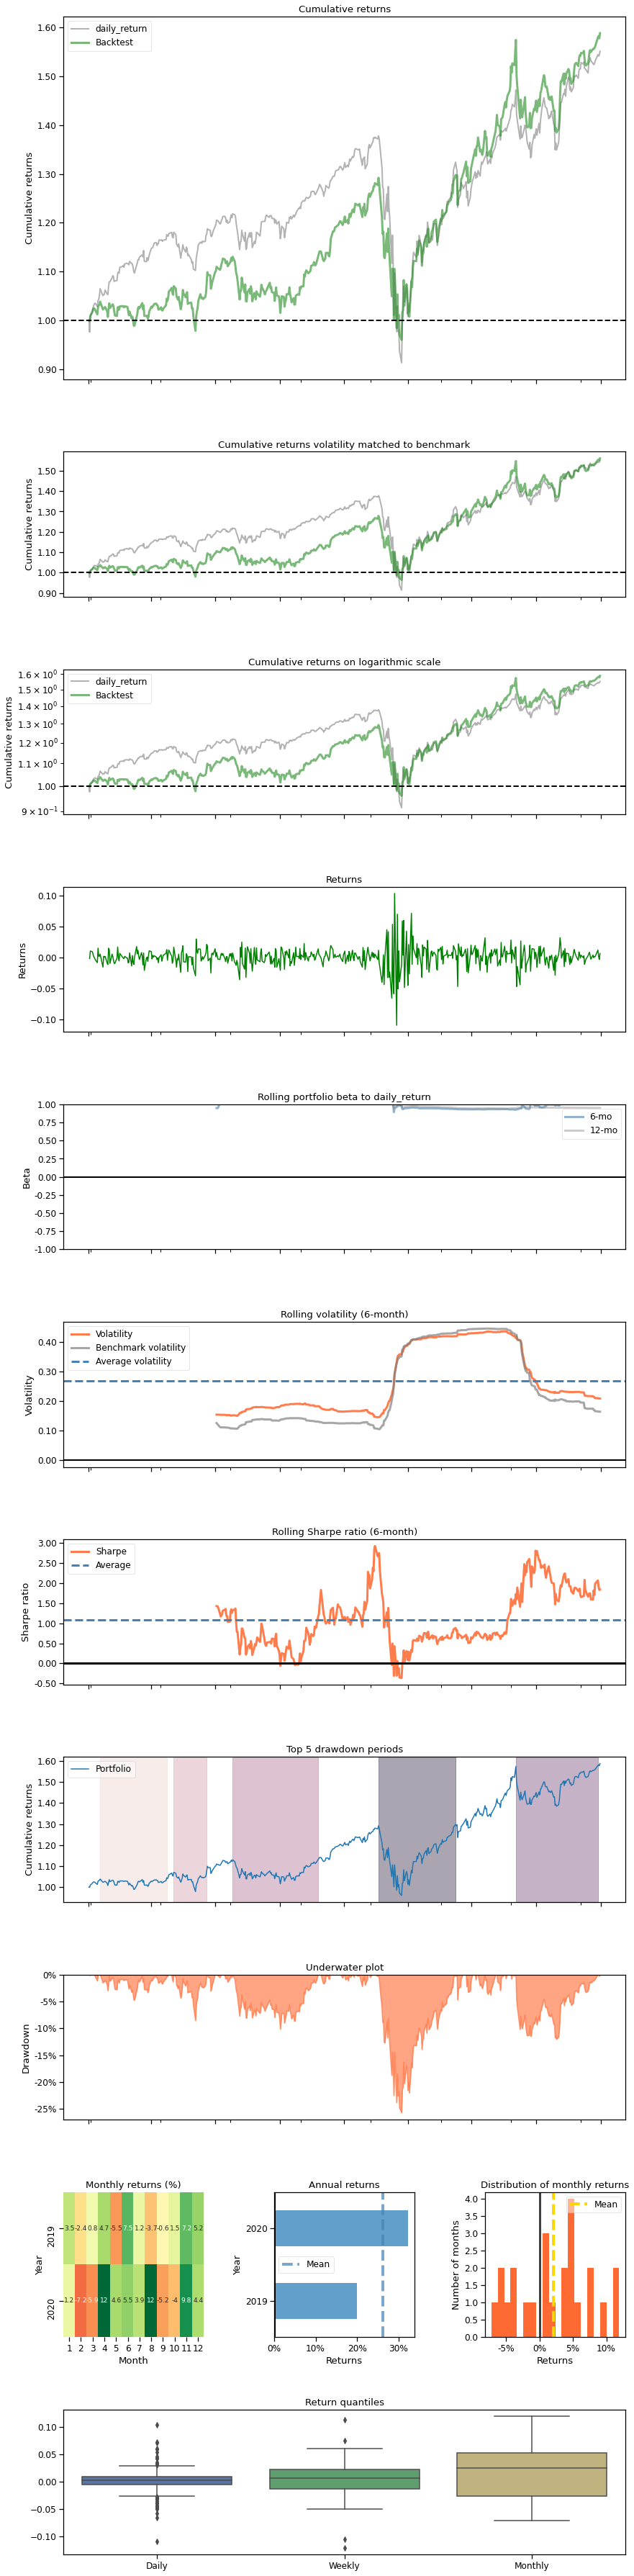

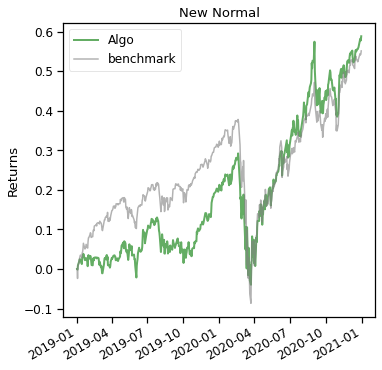

In [37]:
%matplotlib inline
backtest_plot(df_value['evaluation_a2c'], baseline_ticker = 'SPY', baseline_start = split_date, baseline_end = end_date)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,30.051%
Cumulative returns,69.309%
Annual volatility,30.939%
Sharpe ratio,1.01
Calmar ratio,1.09
Stability,0.81
Max drawdown,-27.53%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.53,2020-02-19,2020-03-16,2020-06-08,79
1,13.60,2020-09-02,2020-10-30,NaT,NaN
2,11.20,2019-07-12,2019-10-02,2019-11-27,99
3,9.16,2019-04-30,2019-06-03,2019-06-20,38
4,5.74,2020-06-10,2020-06-11,2020-06-18,7


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.12%,-13.56%,14.51%


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


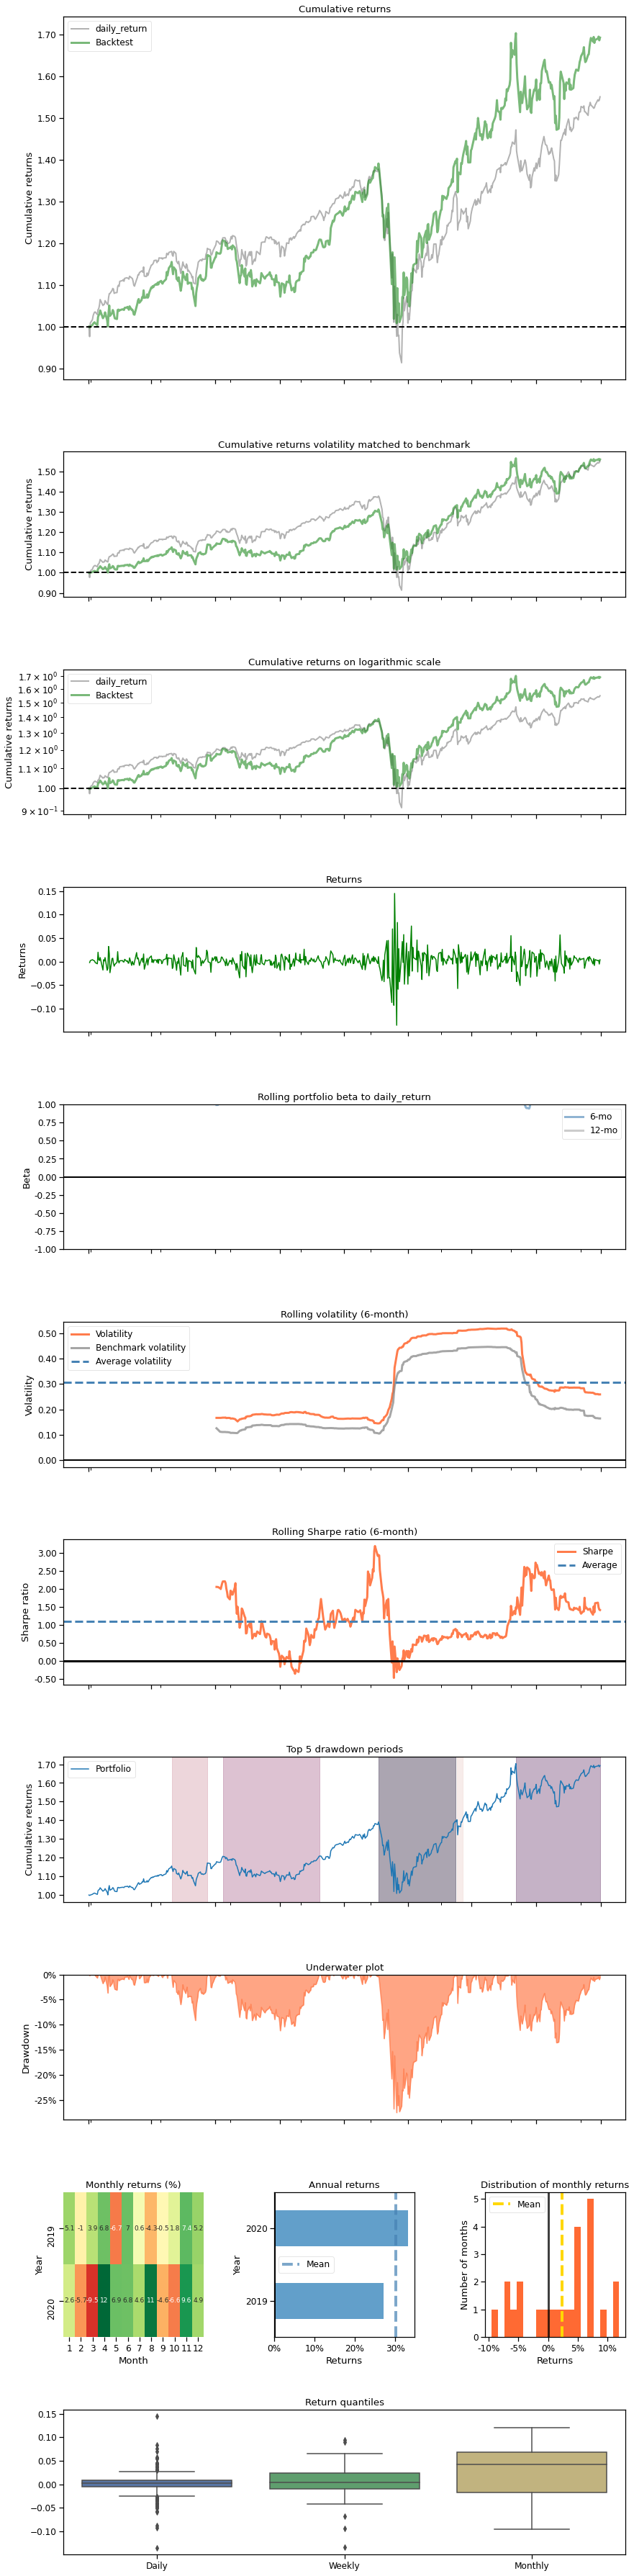

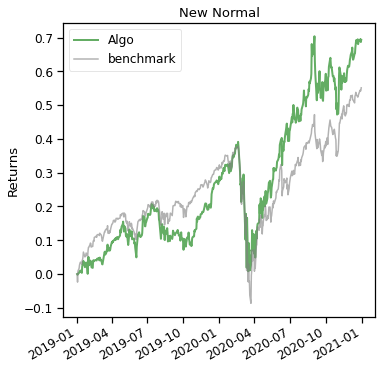

In [38]:
%matplotlib inline
backtest_plot(df_value['evaluation_ppo'], baseline_ticker = 'SPY', baseline_start = split_date, baseline_end = end_date)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,31.534%
Cumulative returns,73.201%
Annual volatility,27.34%
Sharpe ratio,1.14
Calmar ratio,1.09
Stability,0.84
Max drawdown,-28.807%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.81,2020-02-19,2020-03-23,2020-06-05,78
1,11.49,2019-04-23,2019-05-31,2019-09-11,102
2,10.06,2020-09-02,2020-10-30,NaT,NaN
3,5.54,2020-06-10,2020-06-11,2020-07-08,21
4,4.27,2019-01-25,2019-01-29,2019-02-01,6


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.12%,-10.65%,10.20%


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


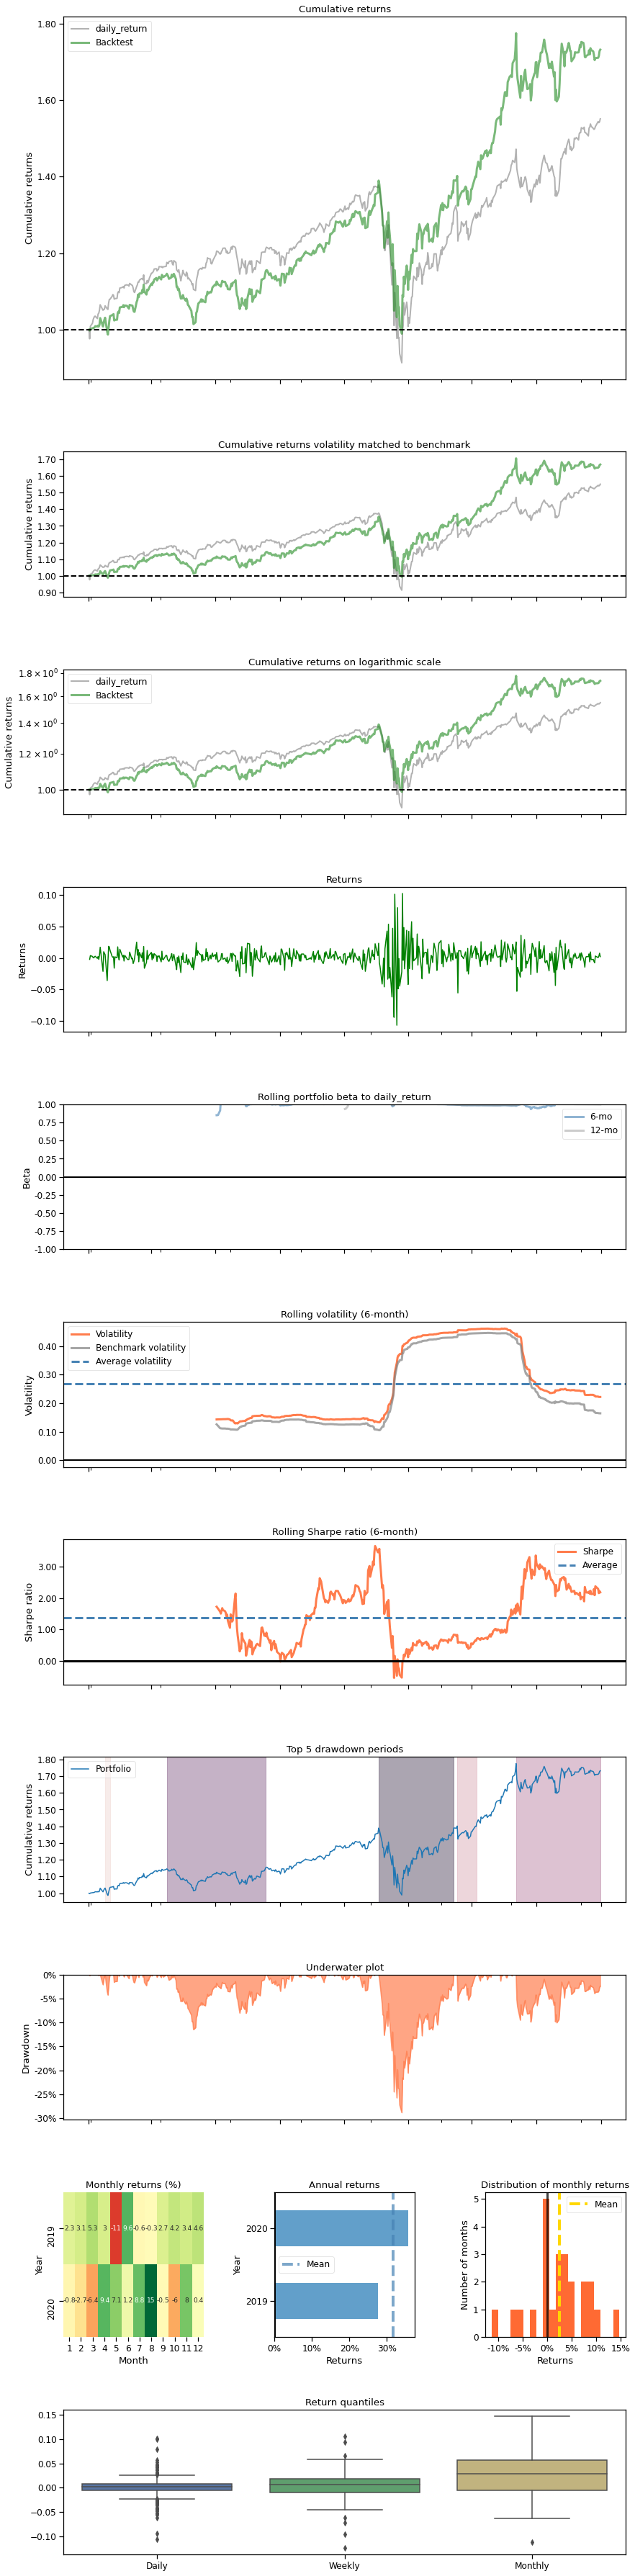

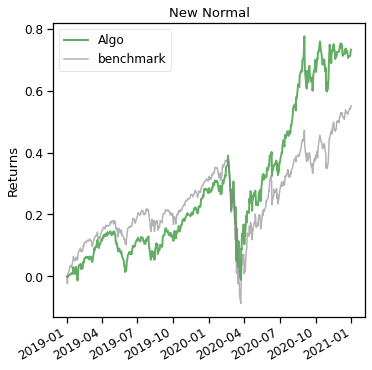

In [39]:
%matplotlib inline
backtest_plot(df_value['evaluation_ddpg'], baseline_ticker = 'SPY', baseline_start = split_date, baseline_end = end_date)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,31.534%
Cumulative returns,73.201%
Annual volatility,27.34%
Sharpe ratio,1.14
Calmar ratio,1.09
Stability,0.84
Max drawdown,-28.807%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.81,2020-02-19,2020-03-23,2020-06-05,78
1,11.49,2019-04-23,2019-05-31,2019-09-11,102
2,10.06,2020-09-02,2020-10-30,NaT,NaN
3,5.54,2020-06-10,2020-06-11,2020-07-08,21
4,4.27,2019-01-25,2019-01-29,2019-02-01,6


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.12%,-10.65%,10.20%


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


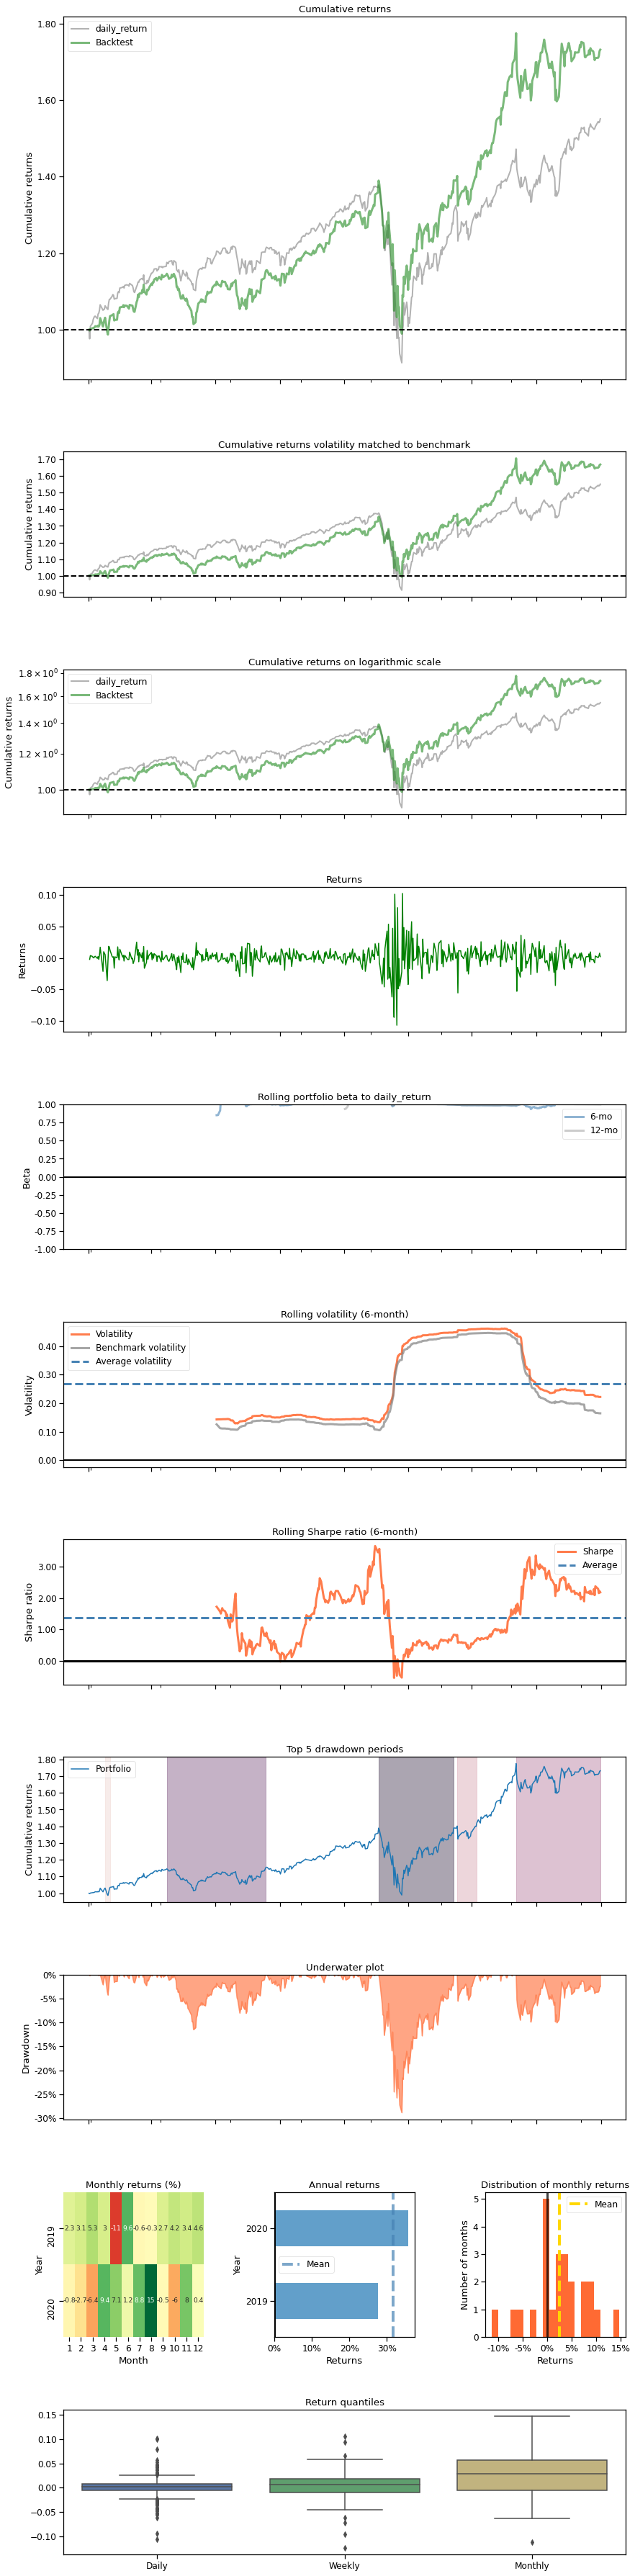

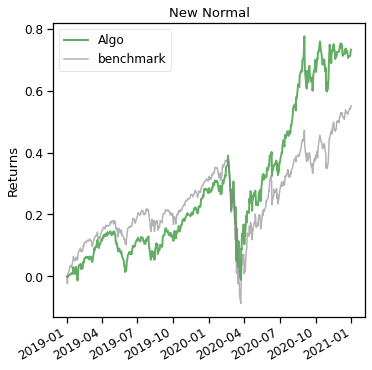

In [40]:
%matplotlib inline
backtest_plot(df_value['evaluation_td3'], baseline_ticker = 'SPY', baseline_start = split_date, baseline_end = end_date)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,31.534%
Cumulative returns,73.201%
Annual volatility,27.34%
Sharpe ratio,1.14
Calmar ratio,1.09
Stability,0.84
Max drawdown,-28.807%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.81,2020-02-19,2020-03-23,2020-06-05,78
1,11.49,2019-04-23,2019-05-31,2019-09-11,102
2,10.06,2020-09-02,2020-10-30,NaT,NaN
3,5.54,2020-06-10,2020-06-11,2020-07-08,21
4,4.27,2019-01-25,2019-01-29,2019-02-01,6


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.12%,-10.65%,10.20%


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


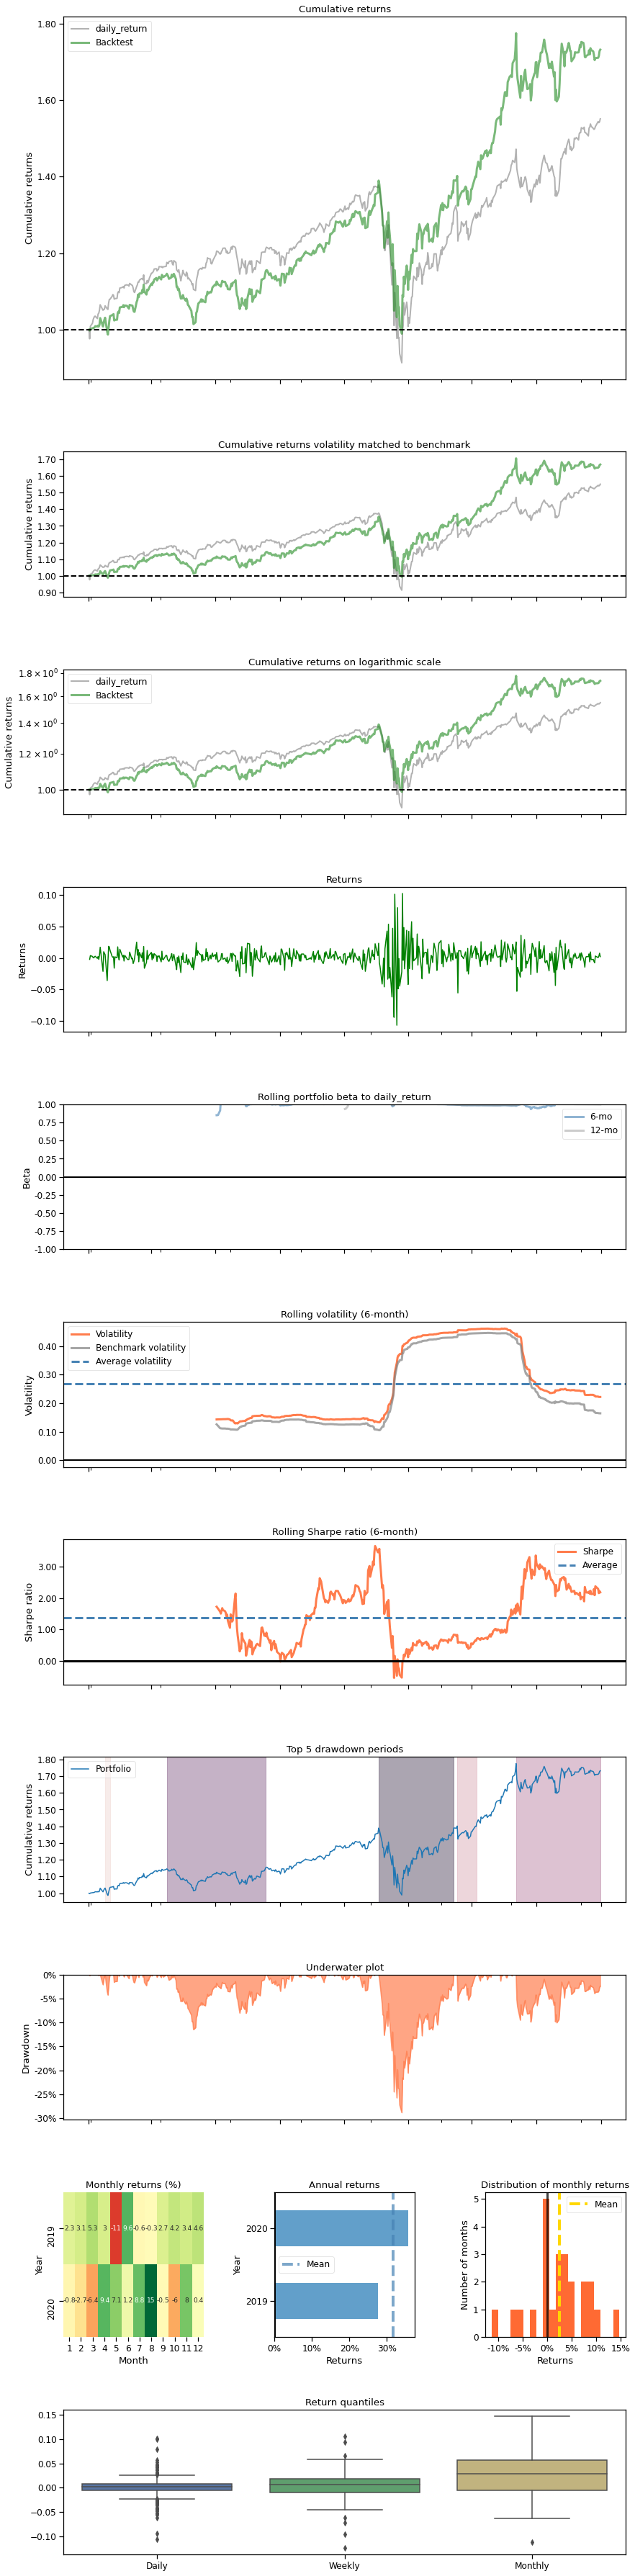

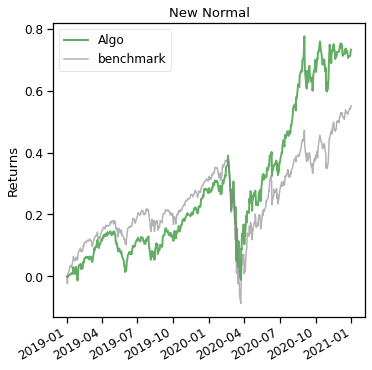

In [41]:
%matplotlib inline
backtest_plot(df_value['evaluation_sac'], baseline_ticker = 'SPY', baseline_start = split_date, baseline_end = end_date)